# Applying the model on the data

In [78]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
import utils


import os
import warnings
warnings.filterwarnings("ignore")
DATA_FOLDER = '../data/'
sales_util = utils.SalesUtils('../submissions')

In [79]:
dfmain  = pd.read_csv(os.path.join(DATA_FOLDER, 'df_main_with_test.csv'))
df_test  = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [80]:
dates = dfmain['date_block_num']

#define the index cols
index_cols = ['shop_id', 'item_id', 'date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [81]:
# List of all lagged features
index_cols = ['shop_id', 'item_id', 'date_block_num']
shift_range = [1,2,3,4,5,6,7,12]
mean_enc_cols = [col for col in dfmain.columns if 'mean' in str(col)]
fit_cols = [col for col in dfmain.columns if col[-1] in [str(item) for item in shift_range]] 
fit_cols = fit_cols + mean_enc_cols + ['city_id','item_category_id','num_days'] #'num_sun'
# We will drop these at fitting stage
to_drop_cols = list(set(list(dfmain.columns)) - (set(fit_cols)|set(index_cols))) 
# + ['date_block_num', 'city_id_mean_target','item_cat_mean_target'] 

In [82]:
fit_cols

['revenue_lag_1',
 'revenue_item_lag_1',
 'revenue_shop_lag_1',
 'target_lag_1',
 'target_item_lag_1',
 'target_shop_lag_1',
 'revenue_lag_2',
 'revenue_item_lag_2',
 'revenue_shop_lag_2',
 'target_lag_2',
 'target_item_lag_2',
 'target_shop_lag_2',
 'revenue_lag_3',
 'revenue_item_lag_3',
 'revenue_shop_lag_3',
 'target_lag_3',
 'target_item_lag_3',
 'target_shop_lag_3',
 'revenue_lag_11',
 'revenue_item_lag_11',
 'revenue_shop_lag_11',
 'target_lag_11',
 'target_item_lag_11',
 'target_shop_lag_11',
 'revenue_lag_12',
 'revenue_item_lag_12',
 'revenue_shop_lag_12',
 'target_lag_12',
 'target_item_lag_12',
 'target_shop_lag_12',
 'shop_id_exp_y_mean',
 'month_mean_target',
 'item_cat_mean_target',
 'item_cat_db_mean_target',
 'shop_id_mean_target',
 'shop_id_db_mean_target',
 'city_id_mean_target',
 'city_db_mean_target',
 'shop_city_mean',
 'city_id',
 'item_category_id',
 'num_days']

In [83]:
to_drop_cols

['parent_cat_id',
 'month',
 'revenue_shop',
 'target_shop',
 'target_item',
 'num_sun',
 'revenue',
 'target',
 'revenue_item']

In [84]:
dfmain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818986 entries, 0 to 5818985
Data columns (total 54 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int64  
 1   item_id                  int64  
 2   date_block_num           int64  
 3   month                    int64  
 4   target                   float64
 5   revenue                  float64
 6   target_shop              float64
 7   revenue_shop             float64
 8   target_item              float64
 9   revenue_item             float64
 10  item_category_id         int64  
 11  parent_cat_id            int64  
 12  city_id                  int64  
 13  num_sun                  int64  
 14  num_days                 int64  
 15  revenue_lag_1            float64
 16  revenue_item_lag_1       float64
 17  revenue_shop_lag_1       float64
 18  target_lag_1             float64
 19  target_item_lag_1        float64
 20  target_shop_lag_1        float64
 21  revenue_

In [87]:
dfmain.item_category_id.max()

83

In [88]:
dfmain['date_block_num'] = dfmain['date_block_num'].astype('int8')
dfmain['shop_id'] = dfmain['shop_id'].astype('int8') #category
dfmain['item_id'] = dfmain['item_id'].astype('int16') #category
dfmain['num_sun'] = dfmain['num_sun'].astype('int8') #category
dfmain['month'] = dfmain['month'].astype('int8') #category
dfmain['item_category_id'] = dfmain['item_category_id'].astype('int8') #category
dfmain['parent_cat_id'] = dfmain['parent_cat_id'].astype('int8') #category
dfmain['city_id'] = dfmain['city_id'].astype('int8') #category
dfmain['num_days'] = dfmain['num_days'].astype('int8') #category

target_cols = [col for col in dfmain.columns if 'target' in str(col)]
for col in target_cols:
    dfmain[col] = dfmain[col].astype('float16')

# getting the mean attributes
mean_enc_cols = [col for col in dfmain.columns if 'mean' in str(col)]
for col in mean_enc_cols:
    dfmain[col] = dfmain[col].astype('float16')
    
# getting the mean attributes
revenue_cols = [col for col in dfmain.columns if 'revenue' in str(col)]
for col in revenue_cols:
    dfmain[col] = dfmain[col].astype('float32')

In [89]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818986 entries, 0 to 5818985
Data columns (total 54 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int8   
 1   item_id                  int16  
 2   date_block_num           int8   
 3   month                    int8   
 4   target                   float16
 5   revenue                  float32
 6   target_shop              float16
 7   revenue_shop             float32
 8   target_item              float16
 9   revenue_item             float32
 10  item_category_id         int8   
 11  parent_cat_id            int8   
 12  city_id                  int8   
 13  num_sun                  int8   
 14  num_days                 int8   
 15  revenue_lag_1            float32
 16  revenue_item_lag_1       float32
 17  revenue_shop_lag_1       float32
 18  target_lag_1             float16
 19  target_item_lag_1        float16
 20  target_shop_lag_1        float16
 21  revenue_

In [90]:
#split
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = dfmain.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
X_test =  dfmain.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_valid = dfmain.loc[dates == last_block-1].drop(to_drop_cols, axis=1)

y_train = dfmain.loc[dates <  last_block-1, 'target'].values
y_test =  dfmain.loc[dates == last_block, 'target'].values
y_valid =  dfmain.loc[dates == last_block-1, 'target'].values

y_train = y_train.clip(0,20)
y_valid = y_valid.clip(0,20)


X_train_final = dfmain.loc[dates <  last_block].drop(to_drop_cols, axis=1)
y_train_final = dfmain.loc[dates <  last_block, 'target'].values

In [91]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5366614 entries, 0 to 5366613
Data columns (total 45 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int8   
 1   item_id                  int16  
 2   date_block_num           int8   
 3   item_category_id         int8   
 4   city_id                  int8   
 5   num_days                 int8   
 6   revenue_lag_1            float32
 7   revenue_item_lag_1       float32
 8   revenue_shop_lag_1       float32
 9   target_lag_1             float16
 10  target_item_lag_1        float16
 11  target_shop_lag_1        float16
 12  revenue_lag_2            float32
 13  revenue_item_lag_2       float32
 14  revenue_shop_lag_2       float32
 15  target_lag_2             float16
 16  target_item_lag_2        float16
 17  target_shop_lag_2        float16
 18  revenue_lag_3            float32
 19  revenue_item_lag_3       float32
 20  revenue_shop_lag_3       float32
 21  target_l

In [57]:
lag_11_attrib = [col for col in dfmain.columns if 'lag_11' in str(col)]
lag_12_attrib = [col for col in dfmain.columns if 'lag_12' in str(col)]

In [58]:
cols_2_remove = lag_11_attrib + lag_12_attrib + ['city_id_mean_target','shop_city_mean','city_id',
                                                'revenue_lag_2','revenue_lag_3','target_shop_lag_1',
                                                'target_shop_lag_3',
                                                 'num_days',
                                                 'revenue_shop_lag_1',
                                                 'target_item_lag_3']
cols_2_remove

['revenue_lag_11',
 'revenue_item_lag_11',
 'revenue_shop_lag_11',
 'target_lag_11',
 'target_item_lag_11',
 'target_shop_lag_11',
 'revenue_lag_12',
 'revenue_item_lag_12',
 'revenue_shop_lag_12',
 'target_lag_12',
 'target_item_lag_12',
 'target_shop_lag_12',
 'city_id_mean_target',
 'shop_city_mean',
 'city_id',
 'revenue_lag_2',
 'revenue_lag_3',
 'target_shop_lag_1',
 'target_shop_lag_3',
 'num_days',
 'revenue_shop_lag_1',
 'target_item_lag_3']

In [59]:
X_train.drop(cols_2_remove, axis=1, inplace=True)
X_valid.drop(cols_2_remove, axis=1, inplace=True)
X_test.drop(cols_2_remove, axis=1, inplace=True)

In [60]:
cat_features = list(X_train.select_dtypes(include=['category']).columns)
len(X_train.columns),len(X_valid.columns),len(X_test.columns)

(23, 23, 23)

In [61]:
len(y_train), len(X_train)

(5366614, 5366614)

In [92]:
#training the LGB
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0
              }

model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train,label=y_train), 
                  150, #categorical_feature=cat_features, 
                  valid_sets=lgb.Dataset(X_valid,label=y_valid), verbose_eval=True,
                 early_stopping_rounds=15)

pred_lgb = model.predict(X_test)

[1]	valid_0's rmse: 1.12616
Training until validation scores don't improve for 15 rounds
[2]	valid_0's rmse: 1.11523
[3]	valid_0's rmse: 1.10529
[4]	valid_0's rmse: 1.09535
[5]	valid_0's rmse: 1.0869
[6]	valid_0's rmse: 1.07744
[7]	valid_0's rmse: 1.069
[8]	valid_0's rmse: 1.06073
[9]	valid_0's rmse: 1.05295
[10]	valid_0's rmse: 1.04627
[11]	valid_0's rmse: 1.04001
[12]	valid_0's rmse: 1.03341
[13]	valid_0's rmse: 1.02822
[14]	valid_0's rmse: 1.02221
[15]	valid_0's rmse: 1.01652
[16]	valid_0's rmse: 1.01189
[17]	valid_0's rmse: 1.00668
[18]	valid_0's rmse: 1.00216
[19]	valid_0's rmse: 0.997203
[20]	valid_0's rmse: 0.99291
[21]	valid_0's rmse: 0.9891
[22]	valid_0's rmse: 0.98505
[23]	valid_0's rmse: 0.981468
[24]	valid_0's rmse: 0.978486
[25]	valid_0's rmse: 0.975382
[26]	valid_0's rmse: 0.972467
[27]	valid_0's rmse: 0.969265
[28]	valid_0's rmse: 0.967038
[29]	valid_0's rmse: 0.964485
[30]	valid_0's rmse: 0.961816
[31]	valid_0's rmse: 0.959331
[32]	valid_0's rmse: 0.957153
[33]	valid_0'

array([0.00448145, 0.01561806, 0.01393204, 0.01528411, 0.00669428,
       0.0172324 , 0.03272422, 0.01046758, 0.01400241, 0.33669764,
       0.04551926, 0.00610352, 0.00812955, 0.01691755, 0.01852164,
       0.06289973, 0.01112809, 0.01483214, 0.00701713, 0.01468461,
       0.01093731, 0.02575114, 0.00773541, 0.00774082, 0.0043035 ,
       0.02169863, 0.00877522, 0.00670996, 0.00716323, 0.00628189,
       0.00286074, 0.01459872, 0.00570577, 0.0049312 , 0.00475193,
       0.00459861, 0.01889845, 0.01987126, 0.02512764, 0.03238061,
       0.0268434 , 0.02672898, 0.00714888, 0.0083573 , 0.01721204],
      dtype=float32)

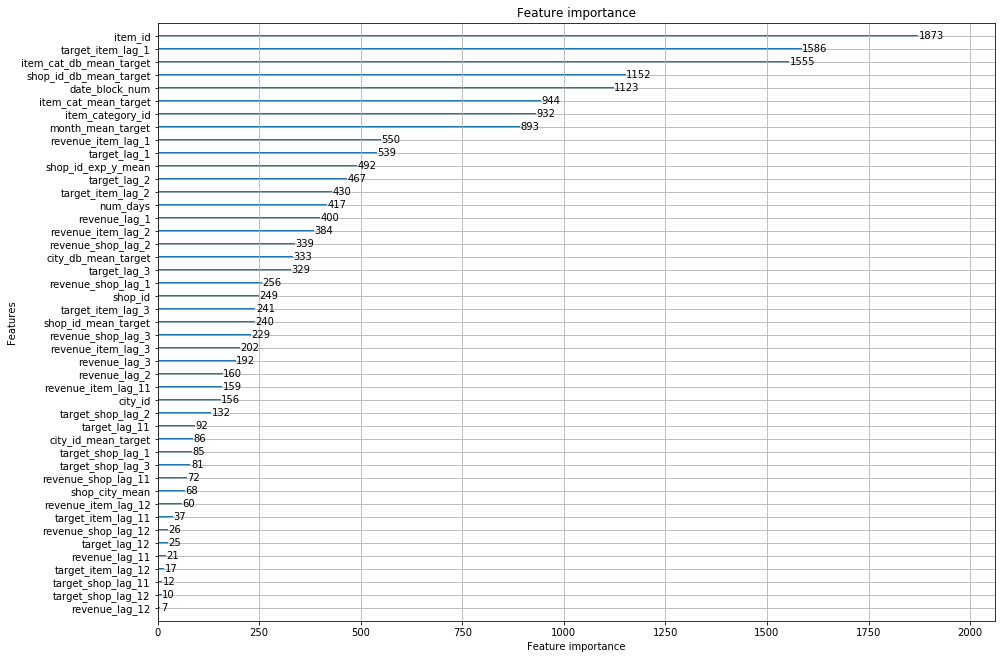

In [93]:
lgb.plot_importance(model, figsize=(15,11))

In [109]:
len(X_train.columns)

45

In [94]:
df_test['item_cnt_month'] = pred_lgb.clip(0,20)
df_submission= df_test[['ID','item_cnt_month']]
sales_util.save_submission('25jul2020_edx_lgb_2',df_submission)

Submission file saved as ../submissions\sub_25jul2020_edx_lgb_2_2020-07-25.csv


### Training on X_Train final

In [97]:
model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train_final,label=y_train_final), 
                  141, #categorical_feature=cat_features, 
                  verbose_eval=True,
                 )
pred_lgb = model.predict(X_test)

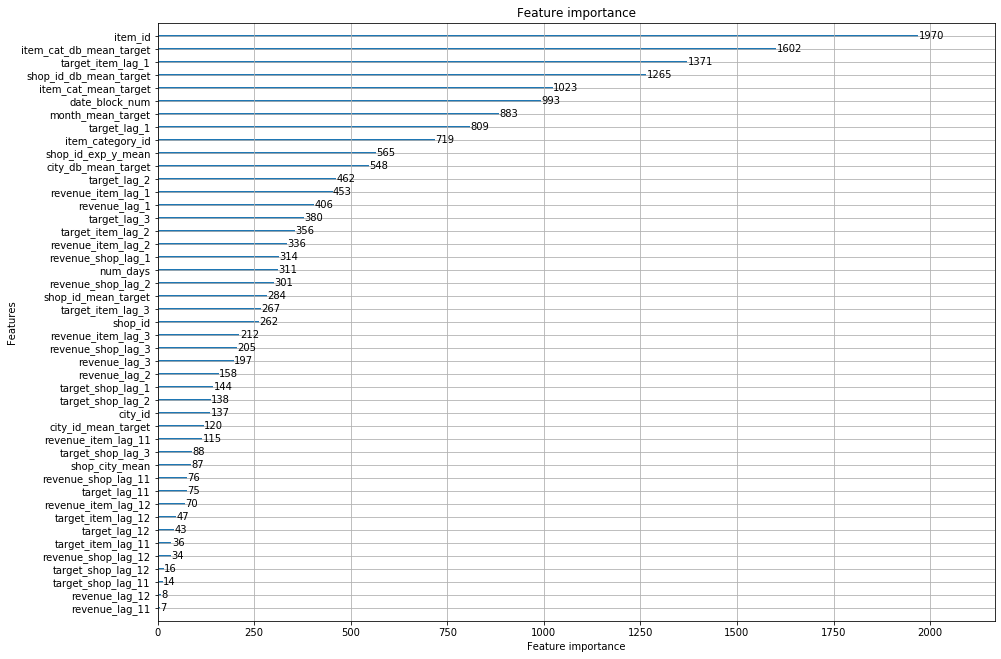

In [98]:
lgb.plot_importance(model, figsize=(15,11))

In [99]:
df_test['item_cnt_month'] = pred_lgb.clip(0,20)
df_submission= df_test[['ID','item_cnt_month']]
sales_util.save_submission('25jul2020_edx_lgb_3',df_submission)

Submission file saved as ../submissions\sub_25jul2020_edx_lgb_3_2020-07-25.csv


In [65]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [70]:
X_train['shop_id'] = X_train['shop_id'].astype('int16')
X_train['item_id'] = X_train['item_id'].astype('int16')
X_train['item_category_id'] = X_train['item_category_id'].astype('int16')
#X_train['city_id'] = X_train['city_id'].astype('int8')
#X_train['num_days'] = X_train['num_days'].astype('int8')


X_valid['shop_id'] = X_valid['shop_id'].astype('int16')
X_valid['item_id'] = X_valid['item_id'].astype('int16')
X_valid['item_category_id'] = X_valid['item_category_id'].astype('int16')
#X_valid['city_id'] = X_valid['city_id'].astype('int8')
#X_valid['num_days'] = X_valid['num_days'].astype('int8')

X_test['shop_id'] = X_test['shop_id'].astype('int16')
X_test['item_id'] = X_test['item_id'].astype('int16')
X_test['item_category_id'] = X_test['item_category_id'].astype('int16')
#X_test['city_id'] = X_test['city_id'].astype('int8')
#X_test['num_days'] = X_test['num_days'].astype('int8')

In [71]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [100]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:1.17277	validation_1-rmse:1.12000
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12961	validation_1-rmse:1.08955
[2]	validation_0-rmse:1.08889	validation_1-rmse:1.06058
[3]	validation_0-rmse:1.05431	validation_1-rmse:1.03662
[4]	validation_0-rmse:1.02485	validation_1-rmse:1.01480
[5]	validation_0-rmse:0.99872	validation_1-rmse:0.99810
[6]	validation_0-rmse:0.97671	validation_1-rmse:0.98284
[7]	validation_0-rmse:0.95790	validation_1-rmse:0.97018
[8]	validation_0-rmse:0.94070	validation_1-rmse:0.95984
[9]	validation_0-rmse:0.92654	validation_1-rmse:0.94917
[10]	validation_0-rmse:0.91413	validation_1-rmse:0.94173
[11]	validation_0-rmse:0.90365	validation_1-rmse:0.93584
[12]	validation_0-rmse:0.89525	validation_1-rmse:0.93172
[13]	validation_0-rmse:0.88748	validation_1-rmse:0.92822
[14]	validation_0-rmse:0.88080	validation_1-rmse:0.92

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [101]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_2.csv', index=False)

# save predictions for an ensemble
#pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
#pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

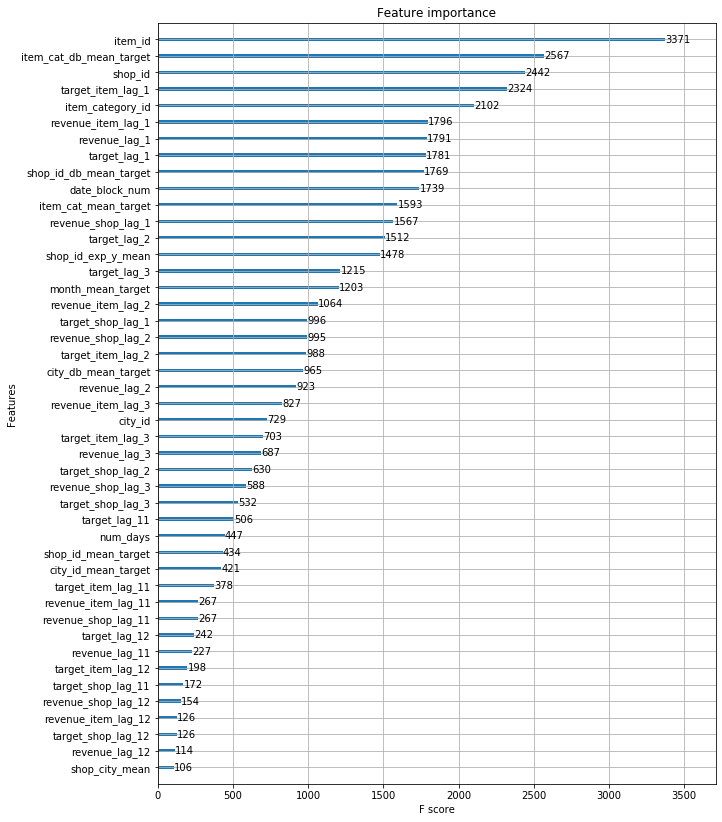

In [102]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))